Download DATA

In [353]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from keras.models import Model
from keras.layers import Input, GRU, Dense, Dropout
from keras.metrics import MeanSquaredError, RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [354]:
ftse100_tickers = [
    "IAG", "MRO", "BAB", "RTO", "SPX", "ENT", "RKT", "BNZL", "HSBA", "HLN",
    "SGE", "SMT", "RR", "HLMA", "EDV", "BA", "BARC", "SHEL", "CPG", "FRES",
    "EXPN", "IHG", "AAL", "EZJ", "LSEG", "HSX", "WPP", "ABF", "RMV", "BTRW",
    "ANTO", "RIO", "PSH", "AUTO", "DPLM", "BKG", "AZN", "GAW", "PSN", "NWG",
    "CRDA", "AV", "FCIT", "AHT", "MNG", "WEIR", "REL", "AAF", "DCC", "MNDI",
    "DGE", "STJ", "ITRK", "TW", "ICG", "GLEN", "SMIN", "CCEP", "PRU", "LGEN",
    "ULVR", "CCH", "PCT", "INF", "III", "ALW", "PSON", "IMI", "PHNX", "NXT",
    "HIK", "JD", "SN", "CNA", "CTEC", "ADM", "SGRO", "BP", "IMB", "STAN",
    "LMP", "UTG", "BATS", "TSCO", "LAND", "NG", "SDR", "HWDN", "BT-A", "MKS",
    "BEZ", "SSE", "GSK", "LLOY", "VOD", "KGF", "SVT", "WTB", "UU", "SBRY"
]

In [355]:
start_dat = "2005-01-04"
end_dat = datetime.today().strftime('%Y-%m-%d')#"2025-05-07"
# company = 'BAB'+".L"
company = ftse100_tickers[10] + ".L"

In [356]:
#prepare data for for next part
def get_data(comapny, startdate, enddate,interval1="1d"):
    df_og = yf.download(comapny, start= startdate, 
                    end= enddate, interval=interval1)
    #index in this case is date, for easier manipulation we want it as a column
    
    df_og.columns = df_og.columns.get_level_values(0) 
    
    df_og = df_og.reset_index()
    # Ensure 'Date' is in datetime format
    df_og['Date'] = pd.to_datetime(df_og['Date'])

    return df_og 

In [357]:
data1 = get_data(company, start_dat, end_dat)
data1.columns

[*********************100%***********************]  1 of 1 completed


Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [358]:
# # show_stattics_histogram(data1)
# plt.figure(figsize=(20, 15))
# plt.plot(data1['Date'], data1['Close'], alpha=0.5, label='Close Price')
# plt.plot(data1['Date'], data1['Volume'], alpha=0.5, label='Volume')
# # data1.plot(kind='line', x='Date', y='Close')#, figsize=(10, 5), title="Price History",xlabel="Date", ylabel="Price")
# # data1.plot(kind='line', x='Date', y='Volume')#, figsize=(10, 5), title="Price History",xlabel="Date", ylabel="Price")
# plt.grid()
# plt.show()

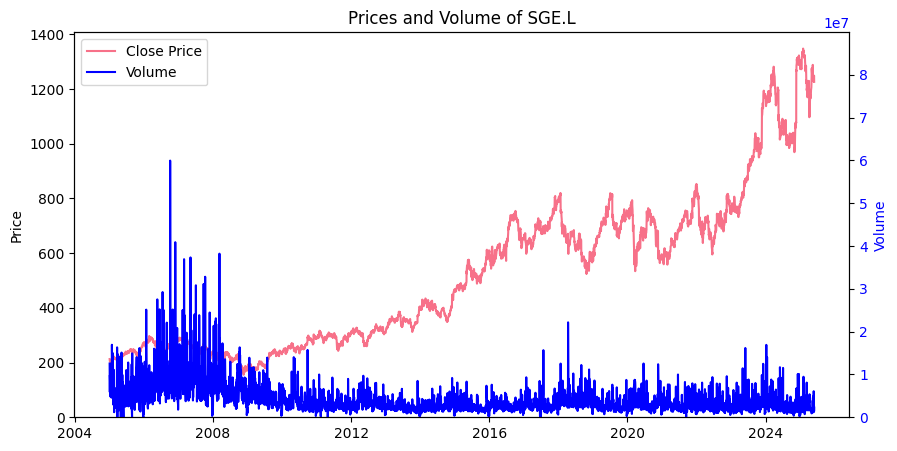

In [359]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Volume on the right y-axis
ax2 = ax1.twinx()
ax2.plot(data1['Date'], data1['Volume'], color='b', label='Volume')
ax2.set_ylabel('Volume', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylim(bottom=0, top=data1['Volume'].max() * 1.5)

# Plot each price column on the left y-axis with different color
price_cols = [col for col in data1.columns if 
              col not in ['Date','Open','Volume', 'High', 'Low']]
colors = sns.color_palette("husl", len(price_cols))

for col, color in zip(price_cols, colors):
    ax1.plot(data1['Date'], data1[col], color=color, label=col + ' Price')
    
ax1.set_ylabel('Price')
ax1.tick_params(axis='y')
ax1.set_ylim(bottom=0)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title("Prices and Volume of " + company)
plt.show()

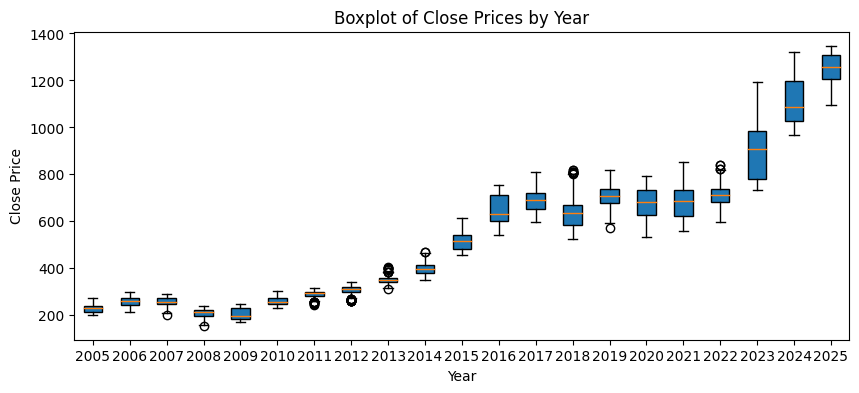

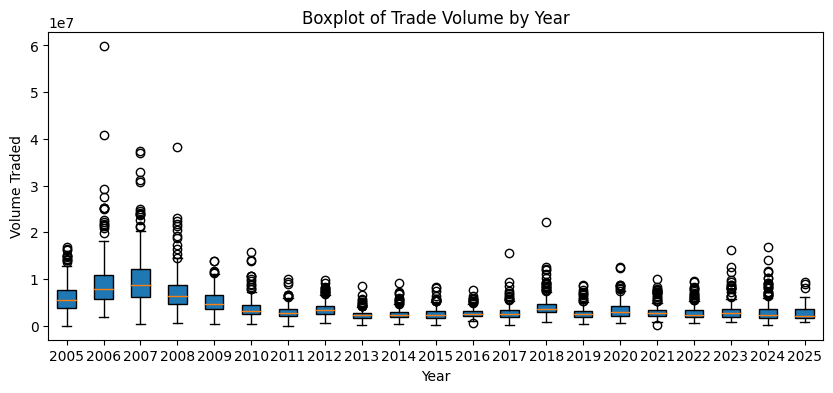

In [360]:
# Ensure 'Date' is datetime
data1['Year'] = data1['Date'].dt.year

# Create a list of Close data for each year
years = sorted(data1['Year'].unique())
data_by_year = [data1[data1['Year'] == year]['Close'].dropna() for year in years]

plt.figure(figsize=(10, 4))
plt.boxplot(data_by_year, labels=years, patch_artist=True)
plt.ylabel('Close Price')
plt.title('Boxplot of Close Prices by Year')
plt.xlabel('Year')
plt.show()
# Ensure 'Date' is datetime and extract year
data1['Date'] = pd.to_datetime(data1['Date'])
data1['Year'] = data1['Date'].dt.year

# Prepare data: list of 'Volume' for each year
# years = sorted(data1['Year'].unique())
data_by_year = [data1[data1['Year'] == year]['Volume'].dropna() for year in years]

plt.figure(figsize=(10, 4))
plt.boxplot(data_by_year, labels=years, patch_artist=True)
plt.ylabel('Volume Traded')
plt.title('Boxplot of Trade Volume by Year')
plt.xlabel('Year')
plt.show()
data1.drop(columns=['Year'], inplace=True)

In [361]:
# Assuming data1 is already defined and has Date, ChangeClose, Volume columns
 #Check for weekends and holidays
data1['prev_date'] = data1['Date'].shift(1)
data1['date_diff'] = (data1['Date'] - data1['prev_date']).dt.days

data1['WeekendOff'] = data1['date_diff'] > 1

# Calculate the percentage change in 'Close' price
data1['prev_Close'] = data1['Close'].shift(1)
data1['ChangeClose'] = abs( data1['Close'] - data1['prev_Close'])
# data1['ChangeClose'].iloc[0] = 0  
data1.loc[0, "ChangeClose"] = 0

data1.drop(columns=['prev_date', 'date_diff','prev_Close'], inplace=True)



In [362]:
# Prepare data
data1['Year'] = data1['Date'].dt.year
years = sorted(data1['Year'].unique())

data_by_year = [data1[data1['Year'] == year]['ChangeClose'].dropna() for year in years]

# High volume calculation
data1['HighVolume'] = data1['Volume'] > 5000000
yearly_stats = data1.groupby('Year').agg(
    total_days=('Date', 'count'),
    high_volume_days=('HighVolume', 'sum')
)
yearly_stats['percent_high_volume'] = (yearly_stats['high_volume_days'] / yearly_stats['total_days']) * 100

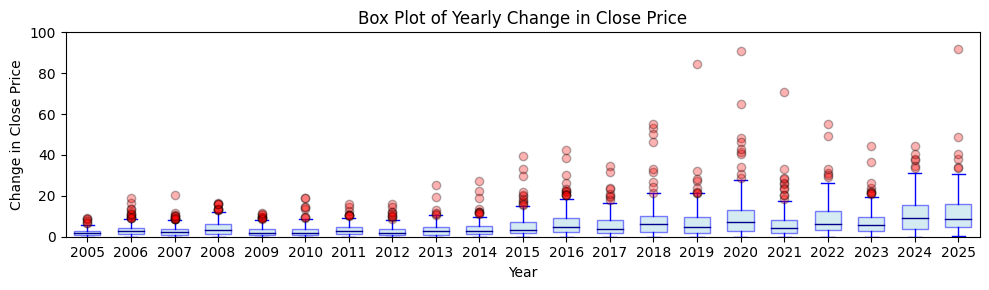

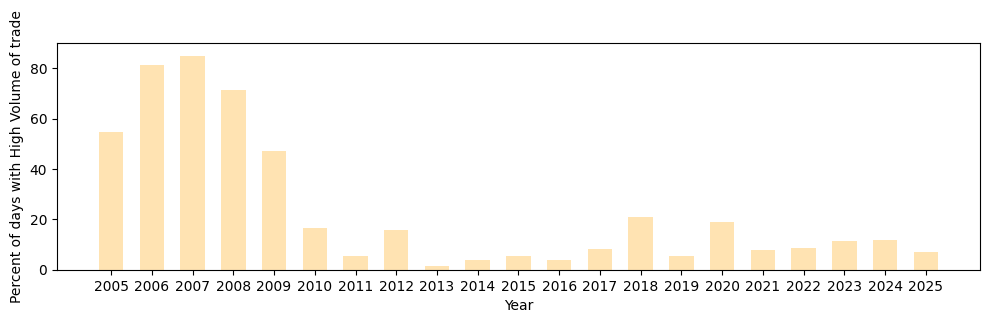

In [363]:
# Plot
fig, ax1 = plt.subplots(figsize=(10, 3))

# Boxplot on left y-axis
box = ax1.boxplot(
    data_by_year,
    positions=np.arange(len(years)),
    patch_artist=True,
    widths=0.6,
    boxprops=dict(facecolor='lightblue', color='blue', alpha=0.5),
    medianprops=dict(color='darkblue'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    flierprops=dict(markerfacecolor='red', marker='o', alpha=0.3)
)
ax1.set_ylabel('Change in Close Price')
ax1.set_xlabel('Year')
ax1.set_xticks(np.arange(len(years)))
ax1.set_xticklabels(years)
ax1.set_title('Box Plot of Yearly Change in Close Price')
ax1.set_ylim(0, 100)



plt.tight_layout()
plt.show()
# Bar plot on right y-axis
fig, ax1 = plt.subplots(figsize=(10, 3))
# ax1 = ax1.twinx()
bar = ax1.bar(
    np.arange(len(years)),
    yearly_stats['percent_high_volume'].reindex(years).fillna(0),
    alpha=0.3, width=0.6,
    color='orange',
    label='Percent High Volume Days'
)
ax1.set_ylabel('Percent of days with High Volume of trade')
ax1.set_ylim(0, 90)
ax1.set_xlabel('Year')
ax1.set_xticks(np.arange(len(years)))
ax1.set_xticklabels(years)
# Legends
# ax1.legend([box["boxes"][0]], ['ChangeClose (boxplot)'], loc='upper left')
# ax2.legend([bar], ['% High Volume Days'], loc='upper right')
# Show the plot
plt.tight_layout()
plt.show()


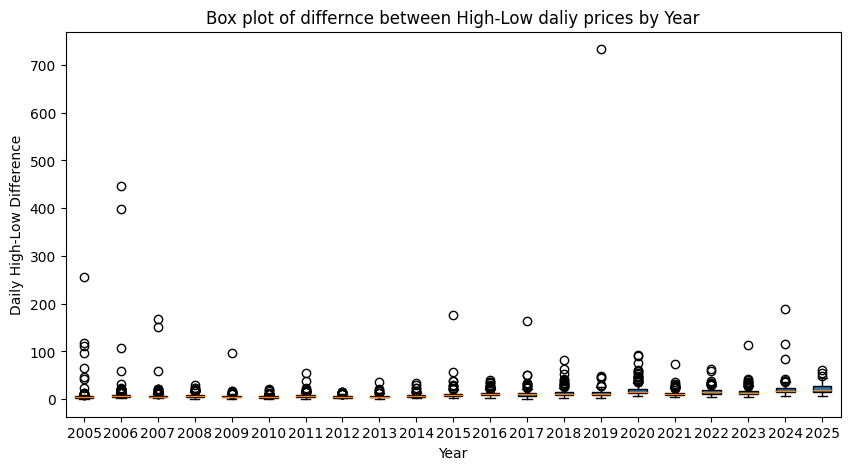

In [364]:
# 1. Calculate the difference for each row
data1['HighLowDiff'] = data1['High'] - data1['Low']

# 2. Prepare data for boxplot
years = sorted(data1['Year'].unique())
diffs_by_year = [data1[data1['Year'] == year]['HighLowDiff'].dropna() for year in years]

# 3. Plot boxplot
plt.figure(figsize=(10, 5))
plt.boxplot(diffs_by_year, labels=years, patch_artist=True)
plt.ylabel('Daily High-Low Difference')
plt.xlabel('Year')
plt.title('Box plot of differnce between High-Low daliy prices by Year')
plt.show()


In [365]:
# data1.drop(columns=['Year'], inplace=True)
# data1.head(5)

In [366]:
# getting data in time series format
def Test_train_validation(data,ratio_train=0.6, ratio_val=0):
    # Drop rows with missing values
    df_og = data.copy()
    df_og = df_og.dropna()
    df_og = df_og.sort_values('Date')
    # Calculate the split index
    split_idx1 = int(len(df_og) * ratio_train)
    train_df = df_og.iloc[:split_idx1]

    if ratio_val == 0 :
        test_df = df_og.iloc[split_idx1:]
        return train_df, test_df

    split_idx2 = int(len(df_og) * (ratio_train + ratio_val))

    val_df = df_og.iloc[split_idx1:split_idx2]
    test_df = df_og.iloc[split_idx2:]

    return train_df, val_df,test_df    

In [367]:
n_input = int(360 * 1.2)
n_output = 1
Trains_split = 0.6
Valitaion_split = 0.2

In [368]:
data2 = data1[['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'WeekendOff',
       'ChangeClose', 'HighVolume', 'HighLowDiff']]
train_data1, val_data1, test_data1 = Test_train_validation(data1, Trains_split, Valitaion_split)

In [369]:
# Feature order used in Creat_sequence
feature_names = ['Close', 'High', 'Low', 'Open', 'Volume', 
                 'WeekendOff', 'ChangeClose', 'HighVolume', 'HighLowDiff']

# Columns to scale
minmax_cols = ['Close', 'High', 'Low', 'Open', 'ChangeClose', 'HighLowDiff']
standard_cols = ['Volume']
binary_cols = ['WeekendOff', 'HighVolume']

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Fit scalers
minmax_scaler.fit(train_data1[minmax_cols])
standard_scaler.fit(train_data1[standard_cols])
train_data = train_data1.copy()
val_data = val_data1.copy()
test_data = test_data1.copy()

In [370]:
#tranforme
train_data[minmax_cols]= minmax_scaler.transform(train_data1[minmax_cols])
val_data[minmax_cols]= minmax_scaler.transform(val_data1[minmax_cols])
test_data[minmax_cols]= minmax_scaler.transform(test_data1[minmax_cols])

#
train_data[standard_cols]= standard_scaler.transform(train_data1[standard_cols])
val_data[standard_cols]= standard_scaler.transform(val_data1[standard_cols])
test_data[standard_cols]= standard_scaler.transform(test_data1[standard_cols])

train_data['HighVolume'] = (train_data['Volume'] > 5).astype(int)
val_data['HighVolume'] = (val_data['Volume'] > 5).astype(int)
test_data['HighVolume'] = (test_data['Volume'] > 5).astype(int)

train_data['Volume'] = np.where(train_data['Volume'] > 5, 5, train_data['Volume'])
val_data['Volume'] = np.where(val_data['Volume'] > 5, 5, val_data['Volume'])
test_data['Volume'] = np.where(test_data['Volume'] > 5, 5, test_data['Volume'])

train_data['WeekendOff'] = train_data['WeekendOff'].astype(int)
val_data['WeekendOff'] = val_data['WeekendOff'].astype(int)
test_data['WeekendOff'] = test_data['WeekendOff'].astype(int)

In [371]:
train_data.head(5)

Price,Date,Close,High,Low,Open,Volume,WeekendOff,ChangeClose,Year,HighVolume,HighLowDiff
0,2005-01-04,0.095804,0.091206,0.174543,0.096567,1.894512,0,0.000000,2005,0,0.022658
1,2005-01-05,0.086626,0.079430,0.168784,0.095690,0.576956,0,0.129655,2005,0,0.014099
2,2005-01-06,0.085315,0.070893,0.165185,0.082972,0.252847,0,0.018521,2005,0,0.007050
3,2005-01-07,0.081381,0.071300,0.162785,0.085165,1.228430,0,0.055566,2005,0,0.011162
4,2005-01-10,0.090122,0.074552,0.163521,0.081218,0.307143,1,0.123478,2005,0,0.014781


In [372]:
train_data.shape,val_data.shape, test_data.shape

((3096, 11), (1032, 11), (1032, 11))

In [373]:
# # Suppose you have only the scaled 'Close' column (e.g., after scaling)
# close_scaled = train_data['Close'].values.reshape(-1, 1)  # shape (n_samples, 1)

# # Prepare a zeros array for all minmax_cols
# all_features = np.zeros((close_scaled.shape[0], len(minmax_cols)))
# close_idx = minmax_cols.index('Close')
# all_features[:, close_idx] = close_scaled[:, 0]

# # Inverse transform using the scaler
# close_inverse = minmax_scaler.inverse_transform(all_features)[:, close_idx]

# # Now close_inverse contains the original 'Close' values
# plt.figure(figsize=(12, 6))
# plt.plot(train_data1['Date'].values, train_data1['Close'].values, label='Original Close')
# # plt.plot(train_data1['Date'].values, close_inverse, label='Reversed Scaled Close', linestyle='--')
# plt.title('Train Data')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()
# plt.show()

In [374]:
def Creat_sequence( data , input_length, output_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - input_length - output_length + 1):
        sequence = data.iloc[i:i + input_length][
            ['Close', 'High', 'Low', 'Open', 'Volume', 
             'WeekendOff', 'ChangeClose', 'HighVolume', 'HighLowDiff']
                ]
        label = data.iloc[i + input_length:
                          i + input_length + output_length][['Close','Volume']]
        
        sequences.append(sequence)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

# Create sequences for training, validation, and testing
train_sequences, train_labels = Creat_sequence(train_data, n_input, n_output)
val_sequences, val_labels = Creat_sequence(val_data, n_input, n_output)
test_sequences, test_labels = Creat_sequence(test_data, n_input, n_output)

In [375]:
train_sequences.shape, train_labels.shape, val_sequences.shape, val_labels.shape, test_sequences.shape, test_labels.shape

((2664, 432, 9),
 (2664, 1, 2),
 (600, 432, 9),
 (600, 1, 2),
 (600, 432, 9),
 (600, 1, 2))

In [376]:
feature_names = ['Close', 'High', 'Low', 'Open', 'Volume', 
                 'WeekendOff', 'ChangeClose', 'HighVolume', 'HighLowDiff']

# Show the first sequence (all timesteps)
pd.DataFrame(train_sequences[0], columns=feature_names).head()

# Or show the first 5 sequences, first timestep of each
for i in range(1):
    display(pd.DataFrame(train_sequences[i], columns=feature_names).head())
    pd.describe_option

,Close,High,Low,Open,Volume,WeekendOff,ChangeClose,HighVolume,HighLowDiff
0,0.095804,0.091206,0.174543,0.096567,1.894512,0.0,0.000000,0.0,0.022658
1,0.086626,0.079430,0.168784,0.095690,0.576956,0.0,0.129655,0.0,0.014099
2,0.085315,0.070893,0.165185,0.082972,0.252847,0.0,0.018521,0.0,0.007050
3,0.081381,0.071300,0.162785,0.085165,1.228430,0.0,0.055566,0.0,0.011162
4,0.090122,0.074552,0.163521,0.081218,0.307143,1.0,0.123478,0.0,0.014781


In [377]:
numerical_cols = ['Close', 'High', 'Low', 'Open', 'Volume', 'ChangeClose', 'HighLowDiff']

flat_train = train_sequences.reshape(-1, train_sequences.shape[2])
df_flat = pd.DataFrame(flat_train, columns=feature_names)

df_flat[numerical_cols] = df_flat[numerical_cols].apply(pd.to_numeric, errors='coerce')
display(df_flat[numerical_cols].describe())

,Close,High,Low,Open,Volume,ChangeClose,HighLowDiff
count,1.150848e+06,1.150848e+06,1.150848e+06,1.150848e+06,1.150848e+06,1.150848e+06,1.150848e+06
mean,2.682154e-01,2.452386e-01,3.301315e-01,2.682002e-01,1.735434e-04,8.273290e-02,1.670113e-02
std,1.857454e-01,1.742596e-01,1.692975e-01,1.862083e-01,9.521471e-01,8.417611e-02,3.079173e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.194747e+00,0.000000e+00,0.000000e+00
25%,1.435316e-01,1.294786e-01,2.172531e-01,1.435888e-01,-6.133995e-01,2.471587e-02,9.407437e-03
50%,2.156176e-01,1.952543e-01,2.823255e-01,2.141440e-01,-3.131673e-01,5.930967e-02,1.293289e-02
75%,3.375544e-01,3.076672e-01,3.933196e-01,3.362271e-01,2.921885e-01,1.136989e-01,1.810241e-02
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00


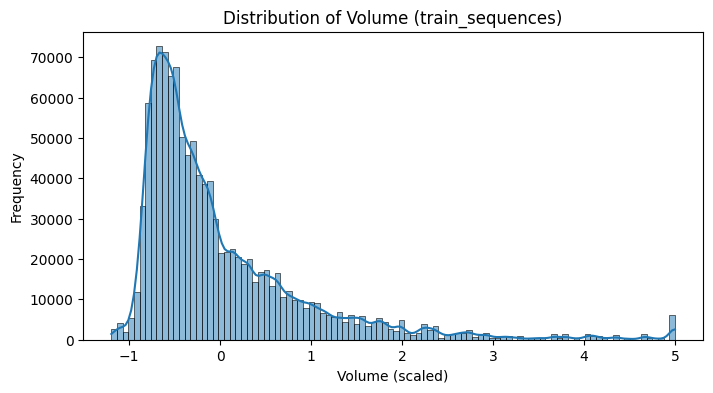

In [378]:
# 'Volume' column index
volume_idx = feature_names.index('Volume')

# Flatten all sequences and timesteps for Volume
volume_flat = train_sequences[:, :, volume_idx].reshape(-1)

plt.figure(figsize=(8, 4))
sns.histplot(volume_flat, bins=100, kde=True)
plt.title('Distribution of Volume (train_sequences)')
plt.xlabel('Volume (scaled)')
plt.ylabel('Frequency')
plt.show()

In [379]:
train_sequences.shape, train_labels.shape, val_sequences.shape, val_labels.shape, test_sequences.shape, test_labels.shape

((2664, 432, 9),
 (2664, 1, 2),
 (600, 432, 9),
 (600, 1, 2),
 (600, 432, 9),
 (600, 1, 2))

In [380]:
print("Shape:", train_sequences.shape)
print("Dtype:", train_sequences.dtype)
train_sequences1 = train_sequences.astype(np.float32)
print("Any NaN:", np.isnan(train_sequences1).any())
print("Any Inf:", np.isinf(train_sequences1).any())

Shape: (2664, 432, 9)
Dtype: float64
Any NaN: False
Any Inf: False


Creat/train Model

In [381]:
#set model parameters

def Creat_model(input_length, input_features, output_length,
                optimizer1='adam', loss1='mean_squared_error',
    metrics1=[MeanSquaredError(), RootMeanSquaredError()]):
    
    # Build the model
    # Input layer
    input_layer = Input(shape=(input_length, input_features), name="Input_Layer")  
    
    # GRU layers
    X = GRU(units=64, return_sequences=True, name="GRU_Layer1")(input_layer)  # Return sequences for next GRU
    X = Dropout(0.2, name="Dropout1")(X)  # Prevent overfitting

    X = GRU(units=32, return_sequences=False, name="GRU_Layer2")(X)  # Final GRU output
    X = Dropout(0.2, name="Dropout2")(X)

    # Dense layers
    X = Dense(16, activation='relu', name="Dense_Layer")(X)

    # Output layer
    output_layer = Dense(output_length, name="Output_Layer")(X)


    # Create the model
    model1 = Model(inputs=input_layer, outputs=output_layer) 

    # Compile the model
    model1.compile(optimizer=optimizer1, loss=loss1 ,    metrics=metrics1 ) 
    
    return model1
    
#show model summary



In [393]:
n_input1 = train_sequences.shape[1]
n_feature1= train_sequences.shape[2]
n_output1 = train_labels.shape[2]

model3 = Creat_model(n_input1, n_feature1, n_output1, optimizer1='adam',
                       loss1='mean_squared_error', metrics1=[MeanSquaredError()])
# X_train.shape, y_train.shape, date_train.shape
# model3 =  create_model(n_input -start_seq, 1,n_output, optimizer1='adam', 
                    #    loss1='mean_squared_error',metrics1=[MeanSquaredError()])
# model3.__dict__
model3.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 432, 9)]          0         
                                                                 
 GRU_Layer1 (GRU)            (None, 432, 64)           14400     
                                                                 
 Dropout1 (Dropout)          (None, 432, 64)           0         
                                                                 
 GRU_Layer2 (GRU)            (None, 32)                9408      
                                                                 
 Dropout2 (Dropout)          (None, 32)                0         
                                                                 
 Dense_Layer (Dense)         (None, 16)                528       
                                                                 
 Output_Layer (Dense)        (None, 2)                 34 

In [388]:
#define complie and callback functions
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define the model checkpoint callback
checkpoint_filepath = 'model_checkpoint.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
callbacks1 = [early_stopping, checkpoint_callback]

In [390]:
#Train model
def Train_model(model, X_train, y_train, X_test, y_test, 
            epochs, batch_size, callbacks2=None):
    # history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=1,
    #                     validation_data=(X_test, y_test)
    #                     callbacks = callbacks)
    history = model.fit(
    X_train, y_train,
    epochs=epochs, 
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=2,
    callbacks=callbacks2#[early_stopping, checkpoint_callback]
    )
    return history

In [394]:
# his = Train_model(model3, train_sequences,
#     train_labels, val_sequences, val_labels,
#     20, 32, callbacks1)
history1 = model3.fit(
    train_sequences, train_labels,
    epochs=20, 
    batch_size=32,
    validation_data=(val_sequences, val_labels),
    verbose=2,
    callbacks=callbacks1
)

Epoch 1/20
84/84 - 11s - loss: 0.4271 - mean_squared_error: 0.4271 - val_loss: 0.2676 - val_mean_squared_error: 0.2681 - 11s/epoch - 136ms/step
Epoch 2/20
84/84 - 9s - loss: 0.4196 - mean_squared_error: 0.4203 - val_loss: 0.2876 - val_mean_squared_error: 0.2883 - 9s/epoch - 112ms/step
Epoch 3/20
84/84 - 9s - loss: 0.4193 - mean_squared_error: 0.4200 - val_loss: 0.2773 - val_mean_squared_error: 0.2779 - 9s/epoch - 111ms/step
Epoch 4/20
84/84 - 9s - loss: 0.4189 - mean_squared_error: 0.4182 - val_loss: 0.2815 - val_mean_squared_error: 0.2821 - 9s/epoch - 112ms/step
Epoch 5/20
84/84 - 9s - loss: 0.4187 - mean_squared_error: 0.4171 - val_loss: 0.2956 - val_mean_squared_error: 0.2962 - 9s/epoch - 112ms/step
Epoch 6/20
84/84 - 9s - loss: 0.4183 - mean_squared_error: 0.4190 - val_loss: 0.2669 - val_mean_squared_error: 0.2675 - 9s/epoch - 113ms/step
Epoch 7/20
84/84 - 10s - loss: 0.4187 - mean_squared_error: 0.4192 - val_loss: 0.2736 - val_mean_squared_error: 0.2742 - 10s/epoch - 113ms/step
Ep

Test Model

In [395]:
# plot and acutal input and given output
def plot_his(history, start_epoch=0):
    filds = history.history.keys()
    plt.figure(figsize=(12, 8))
    if 'loss' in filds:
    # Loss
        plt.subplot(2, 2, 1)
        plt.plot(range(start_epoch, len(history.history['loss'])), 
             history.history['loss'][start_epoch:], 
             label='Train Loss')
        if 'val_loss' in filds:
            plt.plot(range(start_epoch, len(history.history['val_loss'])), 
             history.history['val_loss'][start_epoch:], 
             label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    if 'mean_squared_error' in filds:
        # MSE
        plt.subplot(2, 2, 2)
        plt.plot(range(start_epoch, len(history.history['mean_squared_error'])), 
             history.history['mean_squared_error'][start_epoch:], 
             label='Train MSE')
        if 'val_mean_squared_error' in filds:
            plt.plot(range(start_epoch, len(history.history['val_mean_squared_error'])), 
             history.history['val_mean_squared_error'][start_epoch:], 
             label='Validation MSE')
        plt.title('MSE over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('MSE')
        plt.legend()

    if 'root_mean_squared_error' in filds:
    # RMSE
        plt.subplot(2, 2, 3)
        plt.plot(range(start_epoch, len(history.history['root_mean_squared_error'])), 
             history.history['root_mean_squared_error'][start_epoch:], 
             label='Train RMSE')
        if 'val_root_mean_squared_error' in filds:
            plt.plot(range(start_epoch, len(history.history['val_root_mean_squared_error'])), 
             history.history['val_root_mean_squared_error'][start_epoch:], 
             label='Validation RMSE')
        plt.title('RMSE over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.legend()

    plt.tight_layout()
    plt.show()

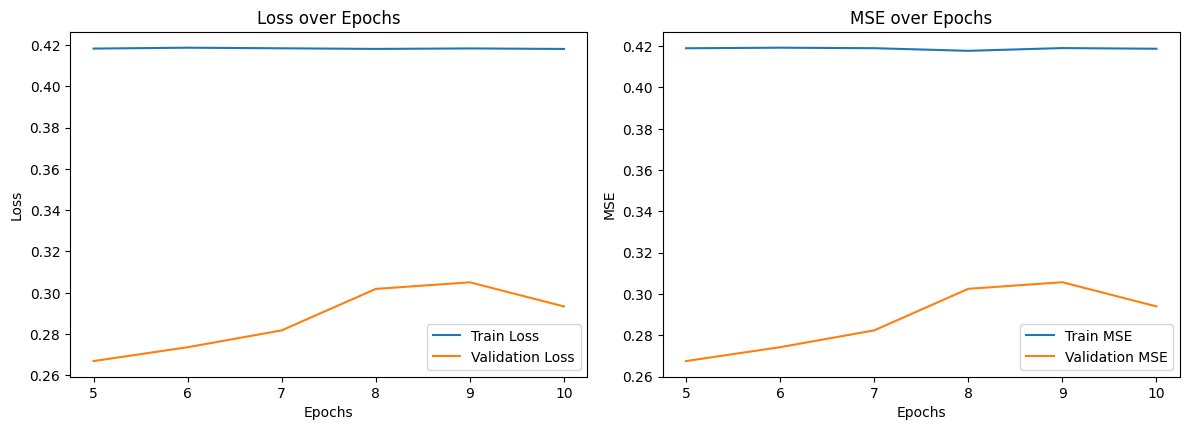

In [396]:
plot_his(history1,5)

In [ ]:
y_pred = model3.predict(test_sequences)
y_pred.shape , test_labels.shape


19/19 [==============================] - 1s 26ms/step


((600, 2), (600, 1, 2))

In [400]:
y_pred

array([[ 0.3524906 , -0.14958337],
       [ 0.35252166, -0.14956976],
       [ 0.34872454, -0.14880496],
       ...,
       [ 0.35120836, -0.1802209 ],
       [ 0.35045743, -0.17516698],
       [ 0.35084474, -0.17609315]], dtype=float32)

In [401]:
Chek_num = 0
y_pred = model3.predict(test_sequences)

y_pred_scaled = y_pred[:,Chek_num].reshape(-1, 1)  # shape (n_samples, 1)
# Prepare a zeros array for all minmax_cols
all_features2 = np.zeros((y_pred_scaled.shape[0], len(minmax_cols)))
close_idx2 = minmax_cols.index('Close')
all_features2[:, close_idx2] = y_pred_scaled[:, 0]
# Inverse transform using the scaler
y_pred_inverse = minmax_scaler.inverse_transform(all_features2)[:, close_idx2]

n_input = int(360 * 1.2)
##############
# Suppose you have only the scaled 'Close' column (e.g., after scaling)
close_scaled = test_labels[:,:,Chek_num].reshape(-1, 1)  # shape (n_samples, 1)

# Prepare a zeros array for all minmax_cols
all_features = np.zeros((close_scaled.shape[0], len(minmax_cols)))
close_idx = minmax_cols.index('Close')
all_features[:, close_idx] = close_scaled[:, 0]

# Inverse transform using the scaler
close_inverse = minmax_scaler.inverse_transform(all_features)[:, close_idx]


19/19 [==============================] - 1s 27ms/step


In [405]:
y_pred_inverse

array([366.60572509, 366.62432696, 364.34979195, 362.41023359,
       363.07567031, 363.95208305, 363.52018739, 360.64410829,
       359.00525056, 359.91545732, 362.16498155, 363.0764915 ,
       363.30951486, 361.45584291, 361.68513517, 363.55865865,
       363.98127122, 361.74708193, 360.70500178, 361.17918904,
       362.17212239, 363.03705623, 362.9855351 , 359.92513315,
       359.53729645, 361.45339717, 361.91933677, 361.45284376,
       359.78385169, 361.20759172, 363.14577547, 364.37785544,
       363.25019236, 361.81925794, 362.43485162, 363.74828357,
       364.04564586, 364.08227835, 361.94240167, 362.71936041,
       364.07315594, 363.98600202, 362.35583826, 360.29583183,
       360.59480082, 362.81256618, 362.77222045, 361.52021755,
       359.12680546, 360.4747455 , 362.11772706, 362.57174146,
       361.38991513, 360.13709103, 361.38846911, 362.96202389,
       363.1707327 , 361.41806788, 360.3092209 , 361.46064512,
       363.21839778, 363.02405991, 362.13338335, 364.13

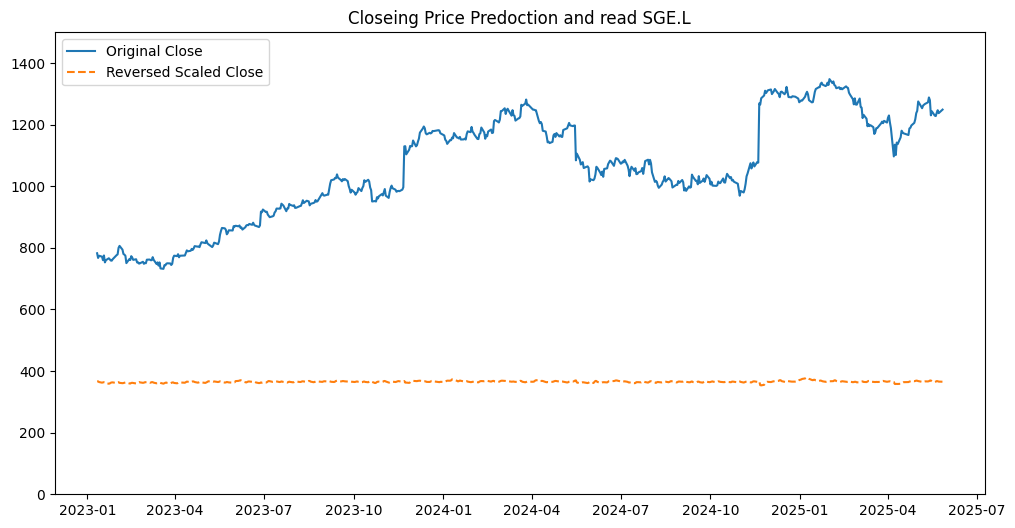

In [408]:
start_p = 0#int(n_input * 0.01)
end_d = 1#int(n_input * 0.01)
# Now close_inverse contains the original 'Close' values
plt.figure(figsize=(12, 6))
plt.plot(test_data1['Date'].values[n_input+start_p:-end_d], close_inverse[start_p:-end_d], label='Original Close')
plt.plot(test_data1['Date'].values[n_input+start_p:-end_d], y_pred_inverse[start_p:-end_d], 
         label='Reversed Scaled Close', linestyle='--')
# plt.plot(close_inverse, label='Original Close')
# plt.plot(y_pred_inverse, label='Reversed Scaled Close', linestyle='--')
plt.title('Closeing Price Predoction and read '+company)
plt.ylim(0,1500)
plt.legend()
plt.show()

In [ ]:
#plot all sequences in one plot
def plot_all(seq_data, model, date):
    i

Evaulate Model

In [ ]:
# GIVE max and min eror
# get trend prediction


Statical information of output

In [ ]:
#statics of input in quater period